<a href="https://colab.research.google.com/github/mrunallll/COVID-19-Visualizations/blob/main/COVID_19_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import datetime
import operator 
import warnings
warnings.filterwarnings("ignore")

In [44]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [45]:
plt.style.use('ggplot')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')


In [38]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,56044,56069,56093,56103,56153,56177,56192,56226,56254,56290,56294,56322,56384,56454,56517,56572,56595,56676,56717,56779,56873,56943,57019,57144,57160,57242,57364,57492,57534,57612,57721,57793,57898,58037,58214,58312,58542,58730,58843,59015
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,119528,120022,120541,121200,121544,121847,122295,122767,123216,123641,124134,124419,124723,125157,125506,125842,126183,126531,126795,126936,127192,127509,127795,128155,128393,128518,128752,128959,129128,129307,129456,129594,129694,129842,129980,130114,130270,130409,130537,130606
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,115842,115970,116066,116157,116255,116349,116438,116543,116657,116750,116836,116946,117061,117192,117304,117429,117524,117622,117739,117879,118004,118116,118251,118378,118516,118645,118799,118975,119142,119323,119486,119642,119805,119992,120174,120363,120562,120736,120922,121112
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11393,11431,11481,11517,11545,11591,11638,11687,11732,11809,11850,11888,11944,12010,12053,12115,12174,12231,12286,12328,12363,12409,12456,12497,12545,12581,12614,12641,12641,12712,12771,12805,12805,12874,12917,12942,13007,13024,13060,13083
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21558,21642,21696,21733,21757,21774,21836,21914,21961,22031,22063,22132,22182,22311,22399,22467,22579,22631,22717,22885,23010,23108,23242,23331,23457,23549,23697,23841,23951,24122,24300,24389,24518,24661,24883,25051,25279,25492,25609,25710


In [15]:
cols = confirmed_df.keys()

In [16]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]

In [17]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []

for i in dates:
    confirmed_sum = confirmed[i].sum() #Summing up the total cases of all countries in a day
    death_sum = deaths[i].sum() #Summing up the total deaths of all countries in a day
    
    #Confirmed, deaths, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    
    #Calculating Mortality rate
    mortality_rate.append(death_sum/confirmed_sum)

In [18]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

window = 7
#Confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

#Deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)


In [19]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)

In [20]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [21]:
start = '1/22/2020'   #22nd Jan, 2020
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [22]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[50:], 
                                                                                            world_cases[50:], 
                                                                                            test_size=0.10, shuffle=False) 

In [23]:
bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

#Bayesian Ridge Polynomial Regression


In [27]:
#Bayesian Ridge Polynomial Regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [28]:
bayesian_search.best_params_

{'alpha_1': 1e-07,
 'alpha_2': 1e-07,
 'lambda_1': 0.001,
 'lambda_2': 1e-07,
 'normalize': False,
 'tol': 0.01}

In [29]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 2814268.0828894535
MSE: 11406450074335.672


#Actual Data VS Predictions

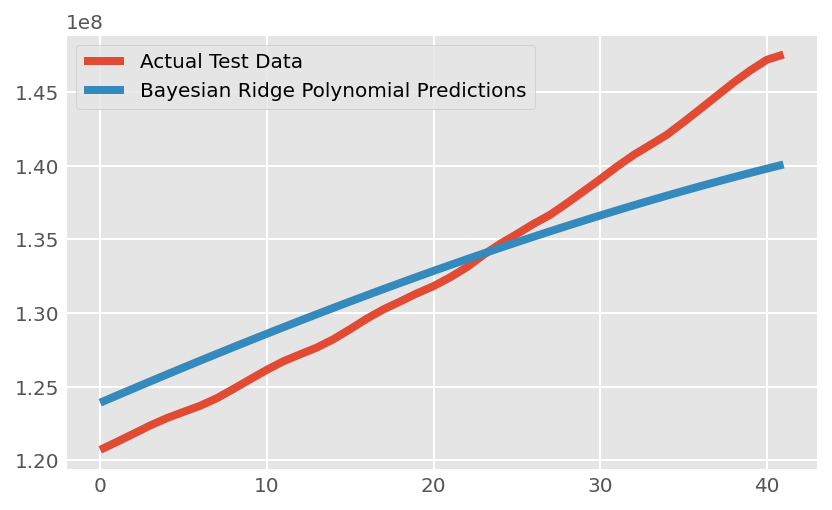

In [46]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Actual Test Data', 'Bayesian Ridge Polynomial Predictions'])

In [31]:
#Flattening the data, so it can be displayed on a bar graph 
def flatten(arr):
    a = [] 
    arr = arr.tolist()
    for i in arr:
        a.append(i[0])
    return a

#Total Worldwide COVID-19 cases till 26th April, 2021

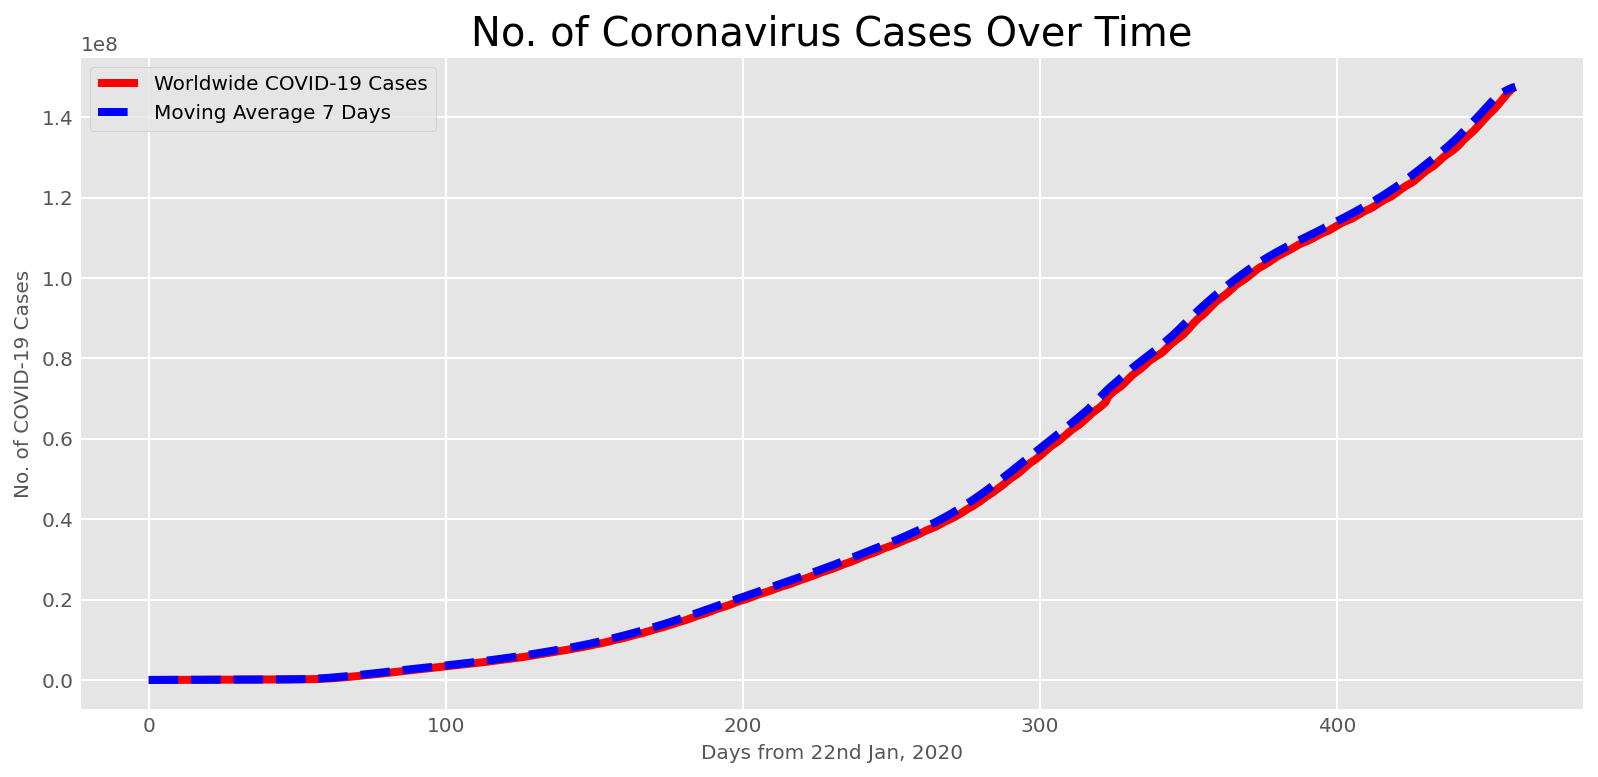

In [56]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(12, 6))
plt.plot(adjusted_dates, world_cases, color='red')
plt.plot(adjusted_dates, world_confirmed_avg, linestyle='dashed', color='blue')
plt.title('No. of Coronavirus Cases Over Time', size=20)
plt.xlabel('Days from 22nd Jan, 2020', size=10)
plt.ylabel('No. of COVID-19 Cases', size=10)
plt.legend(['Worldwide COVID-19 Cases', 'Moving Average {} Days'.format(window)], prop={'size': 10})
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

#Total COVID-19 Deaths Worldwide till 26th April, 2021

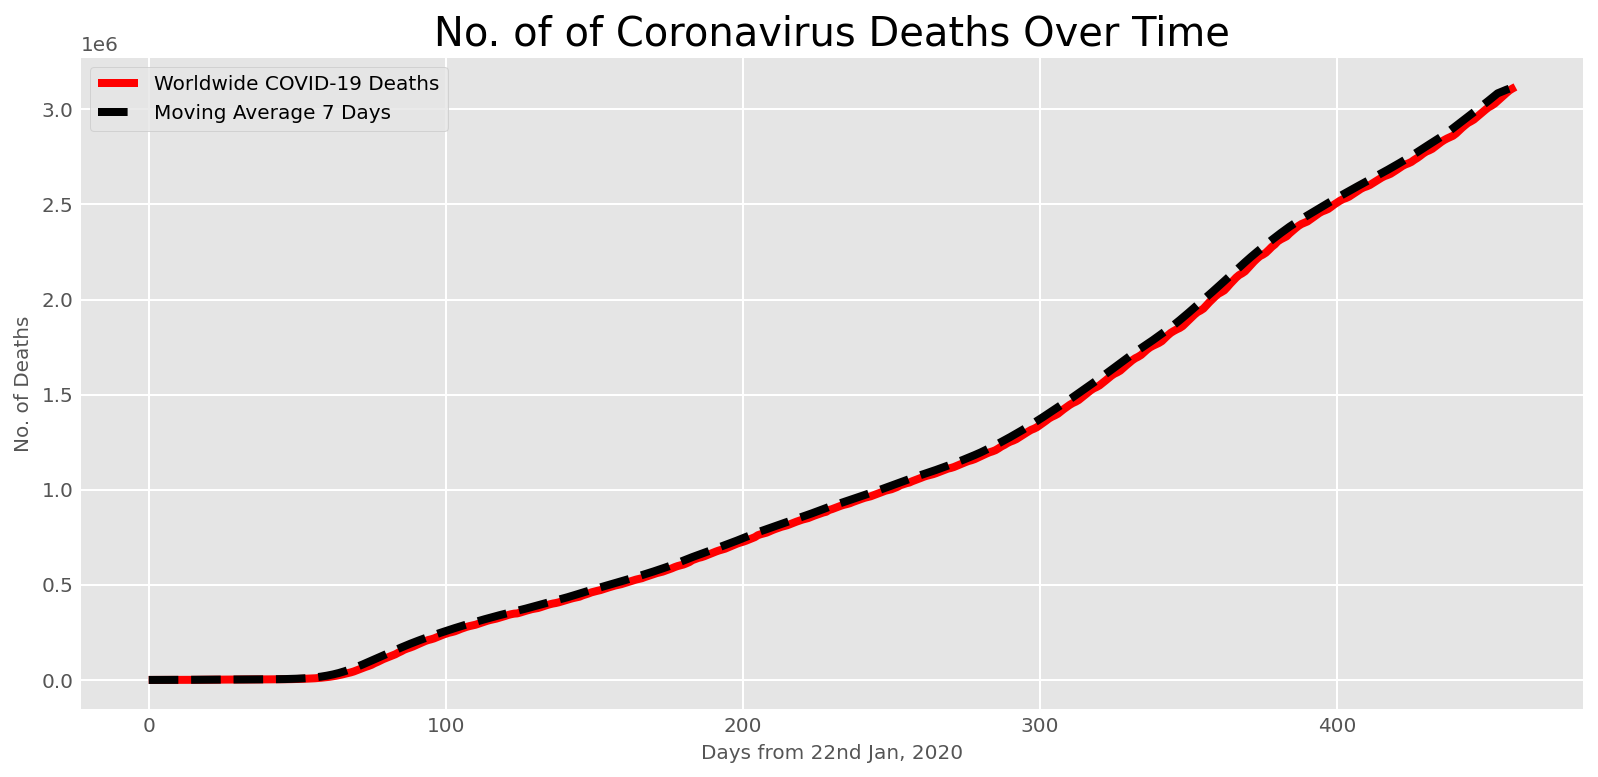

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.plot(adjusted_dates, world_death_avg, linestyle='dashed', color='black')
plt.title('No. of of Coronavirus Deaths Over Time', size=20)
plt.xlabel('Days from 22nd Jan, 2020', size=10)
plt.ylabel('No. of Deaths', size=10)
plt.legend(['Worldwide COVID-19 Deaths', 'Moving Average {} Days'.format(window)], prop={'size': 10})
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

#DAILY INCREASE Frequency Graphs

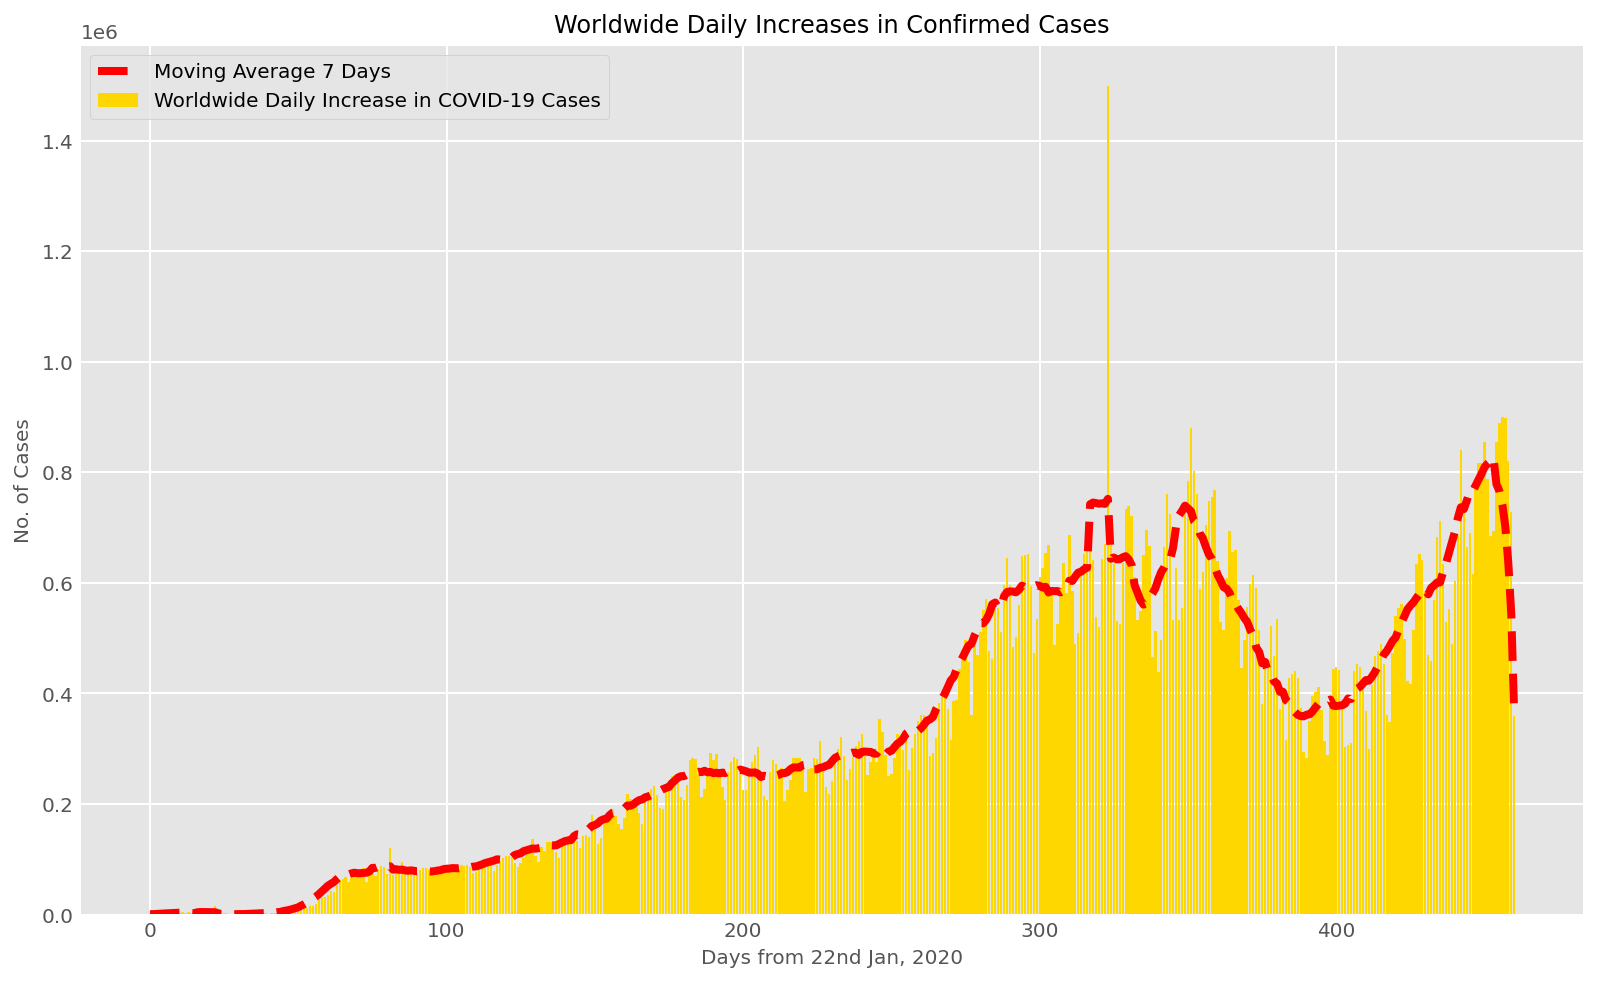

In [61]:
plt.figure(figsize=(12, 8))
plt.bar(adjusted_dates, world_daily_increase, color= 'gold')
plt.plot(adjusted_dates, world_daily_increase_avg, color='red', linestyle='dashed')
plt.title('Worldwide Daily Increases in Confirmed Cases', size=12)
plt.xlabel('Days from 22nd Jan, 2020', size=10)
plt.ylabel('No. of Cases', size=10)
plt.legend(['Moving Average {} Days'.format(window), 'Worldwide Daily Increase in COVID-19 Cases'], prop={'size': 10})
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

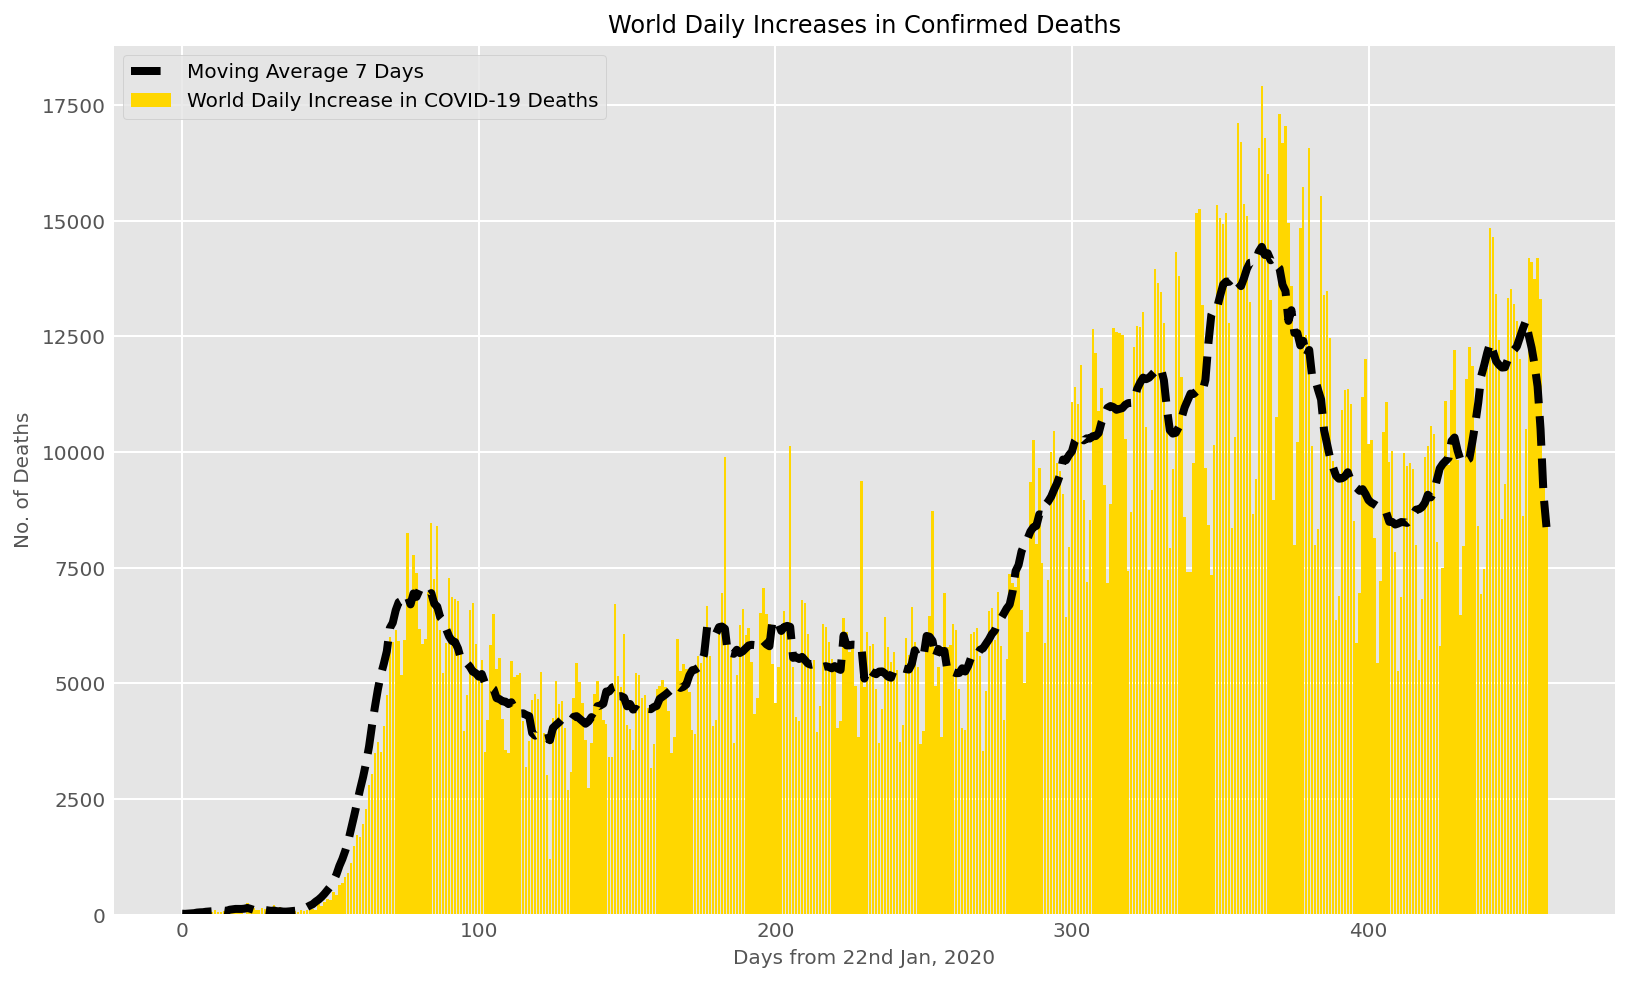

In [62]:
plt.figure(figsize=(12, 8))
plt.bar(adjusted_dates, world_daily_death, color= 'gold')
plt.plot(adjusted_dates, world_daily_death_avg, color='black', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Deaths', size=12)
plt.xlabel('Days from 22nd Jan, 2020', size=10)
plt.ylabel('No. of Deaths', size=10)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Deaths'], prop={'size': 10})
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()